Si convergence study
==================

Let's go through a typical workflow when deciding which cutoffs to use. We are going to use a provided dataset with rattled structures of a Silicon bulk system. We'll analyze the extracting of second and third order force constants.

In [1]:
# Setup plotting, seaborn is just used to make figures look a bit nicer not required
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print('Dont worry')

Start by importing the structures from the provided database and the ideal structure from a POSCAR.
We'll limit ourselves to using only ten training structures throughout this tutorial.

In [2]:
from ase.io import read
from ase.db import connect

db = connect('../../examples/Si_bulk/dft_calculations/structures/silicon-bulk-dft-n5-rattled-0.03.db')
structures = []
for row in db.select():
    structures.append(row.toatoms())
    if len(structures) >= 10:
        break
atoms_ideal = read('../../examples/Si_bulk/dft_calculations/structures/POSCAR_ideal_size5')

Next we prepare the structures to be added to the `StructureContainer`

In [3]:
from hiphive.utilities import get_displacements
for structure in structures:
    structure.arrays['forces'] = structure.get_forces()
    structure.arrays['displacements'] = get_displacements(structure, atoms_ideal)
    structure.positions = atoms_ideal.positions

The the structures are now ideal structures with two added arrays: `displacements` and `forces`

Let's use two other utility functions to find suitable cutoffs. The training structures are based on a 5x5x5 structure, this impose a constraint on the maximum possible cutoff that we can chose. The function `estimate_maximum_cutoff` helps us estimate this maximum_cutoff

In [4]:
import numpy as np
from hiphive.utilities import get_neighbor_shells
from hiphive.cutoffs import estimate_maximum_cutoff

max_cutoff = estimate_maximum_cutoff(atoms_ideal)
shells = get_neighbor_shells(atoms_ideal, max_cutoff)
print('maximum cutoff is', max_cutoff)
for shell in shells:
    print(shell)

neighbor_shells = np.array([shell.distance + 0.1 for shell in shells]).round(1)

maximum cutoff is 9.694411085014286
Si-Si   distance:   2.351671    count: 1000
Si-Si   distance:   3.840262    count: 3000
Si-Si   distance:   4.503106    count: 3000
Si-Si   distance:   5.430950    count: 1500
Si-Si   distance:   5.918241    count: 3000
Si-Si   distance:   6.651529    count: 6000
Si-Si   distance:   7.055012    count: 4000
Si-Si   distance:   7.680524    count: 3000
Si-Si   distance:   8.032484    count: 6000
Si-Si   distance:   8.587087    count: 6000
Si-Si   distance:   8.903281    count: 3000
Si-Si   distance:   9.406682    count: 2000


For convenience we want to reuse already calculated `StructureContainer`s

In [5]:
from functools import lru_cache
from hiphive import ClusterSpace, StructureContainer


@lru_cache(256)
def get_sc(*cutoffs):
    cs = ClusterSpace(atoms_ideal, list(cutoffs))
    sc = StructureContainer(cs)
    for structure in structures:
        sc.add_structure(structure)
    return sc

Let's do a simple loop and calculate the RMSE for some different second order cutoffs (this may take a minute).

In [6]:
import pandas as pd
from trainstation import Optimizer

data = []
for cutoff in neighbor_shells:
    print('Running cutoff {}'.format(cutoff), flush=True)
    sc = get_sc(cutoff)
    opt = Optimizer(sc.get_fit_data())
    opt.train()
    row = dict(second_order_cutoff=cutoff, rmse_test=opt.rmse_test, n_parameters=opt.n_parameters)
    data.append(row)
df = pd.DataFrame(data)

Running cutoff 2.5
Primitive cell:
    Formula: Si2
    Cell:
        [  0.00000   2.71548   2.71548]
        [  2.71548   0.00000   2.71548]
        [  2.71548   2.71548   0.00000]
    Basis:
        Si  [  0.01841   0.01841   0.01841]
        Si  [  0.26841   0.26841   0.26841]

Crystal symmetry:
    Spacegroup:          Fd-3m (227)
    Unique atoms:        1
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 2.5
    Found 2 center atoms with 6 images totaling 8 atoms

Clusters:
    Clusters: {2: 9}
    Total number of clusters: 9

Orbits:
    Orbits: {2: 2}
    Total number of orbits: 2

Eigentensors:
    Eigentensors: {2: 3}
    Total number of parameters: 3

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 2}
    Total number of degrees of freedom: 2
Adding structure
Computing fit matrix
  Building new FCM object
Populating orbits
Done in 0d 0h 0m 6.72s
Done in 0d 0h 0m 2.97s
Adding structure
Computing fit matrix
  Reus

  Reusing old FCM object
Done in 0d 0h 0m 0.0283s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0235s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0228s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0246s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0255s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0236s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.0254s
Running cutoff 6.8
Primitive cell:
    Formula: Si2
    Cell:
        [  0.00000   2.71548   2.71548]
        [  2.71548   0.00000   2.71548]
        [  2.71548   2.71548   0.00000]
    Basis:
        Si  [  0.01841   0.01841   0.01841]
        Si  [  0.26841   0.26841   0.26841]

Crystal symmetry:
    Spacegroup:          Fd-3m (227)
    Unique atoms:        1
    Symmetry operations: 48
    symprec:             1.00e

Orbits:
    Orbits: {2: 12}
    Total number of orbits: 12

Eigentensors:
    Eigentensors: {2: 44}
    Total number of parameters: 44

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 43}
    Total number of degrees of freedom: 43
Adding structure
Computing fit matrix
  Building new FCM object
Populating orbits
Done in 0d 0h 0m 27.6s
Done in 0d 0h 0m 0.121s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.133s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.134s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.132s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.132s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.129s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.133s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 0.127s
Adding st

And plot it

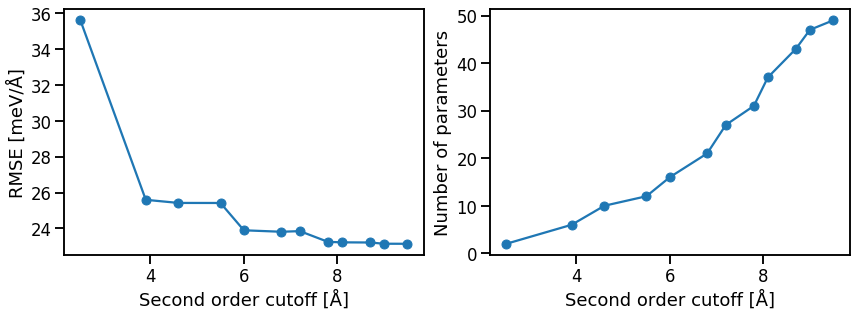

In [7]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 4.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df.second_order_cutoff, 1000*df.rmse_test, '-o')
ax2.plot(df.second_order_cutoff, df.n_parameters, '-o')
ax1.set_xlabel('Second order cutoff [Å]')
ax1.set_ylabel('RMSE [meV/Å]')
ax2.set_xlabel('Second order cutoff [Å]')
ax2.set_ylabel('Number of parameters')
fig.tight_layout()

As we can see the RMSE decreases with increasing cutoff as expected. Note also that not all pairs are created equally. Some pair interactions do almost nothing for the overall RMSE.

We select the longest possible second order cutoff.

Now let's do the same for the third order cutoff (may take a minute or two).

In [8]:
second_order_cutoff = neighbor_shells[-1]
data = []
for cutoff in neighbor_shells[:6]:
    print('Running cutoff {}'.format(cutoff), flush=True)    
    sc = get_sc(second_order_cutoff, cutoff)
    opt = Optimizer(sc.get_fit_data())
    opt.train()
    row = dict(third_order_cutoff=cutoff, rmse_test=opt.rmse_test, n_parameters=opt.n_parameters)
    data.append(row)
df = pd.DataFrame(data)

Running cutoff 2.5
Primitive cell:
    Formula: Si2
    Cell:
        [  0.00000   2.71548   2.71548]
        [  2.71548   0.00000   2.71548]
        [  2.71548   2.71548   0.00000]
    Basis:
        Si  [  0.01841   0.01841   0.01841]
        Si  [  0.26841   0.26841   0.26841]

Crystal symmetry:
    Spacegroup:          Fd-3m (227)
    Unique atoms:        1
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 9.5
    Found 2 center atoms with 196 images totaling 198 atoms

Clusters:
    Clusters: {2: 333, 3: 16}
    Total number of clusters: 349

Orbits:
    Orbits: {2: 14, 3: 2}
    Total number of orbits: 16

Eigentensors:
    Eigentensors: {2: 50, 3: 5}
    Total number of parameters: 55

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 49, 3: 3}
    Total number of degrees of freedom: 52
Adding structure
Computing fit matrix
  Building new FCM object
Populating orbits
Done in 0d 0h 0m 34.7s
Done in 0d 0h 0m 0.0926s
Add

Done in 0d 0h 0m 1.49s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.47s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.47s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.48s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.47s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.48s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.48s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.46s
Adding structure
Computing fit matrix
  Reusing old FCM object
Done in 0d 0h 0m 1.46s
Running cutoff 6.8
Primitive cell:
    Formula: Si2
    Cell:
        [  0.00000   2.71548   2.71548]
        [  2.71548   0.00000   2.71548]
        [  2.71548   2.71548   0.00000]
    Basis:
        Si  [  0.01841   0.01841   0.01841]
        Si  [  0.26841   0.26841   0.26841]

Crystal

And plot it...

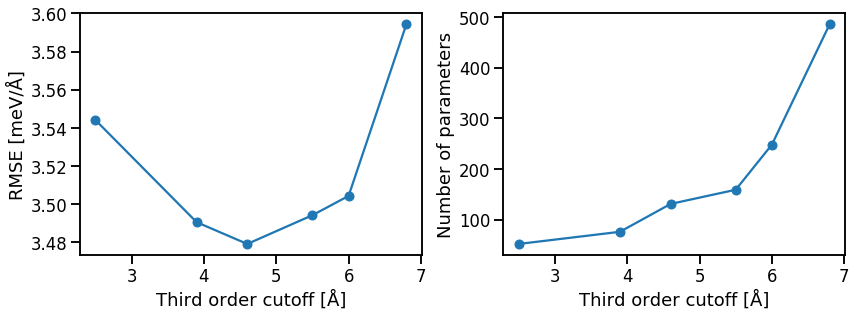

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 4.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df.third_order_cutoff, 1000*df.rmse_test, '-o')
ax2.plot(df.third_order_cutoff, df.n_parameters, '-o')
ax1.set_xlabel('Third order cutoff [Å]')
ax1.set_ylabel('RMSE [meV/Å]')
ax2.set_xlabel('Third order cutoff [Å]')
ax2.set_ylabel('Number of parameters')
fig.tight_layout()

The firs neighbor shell is very important and decreases the RMSE from 23 to around 3.6 meV. Adding more third order interactions will decrease the RMSE even more but after a while the RMSE will start to increase due to overfitting. The number of parameters grows rapidly with third-order cutoff which likely contributes to the overfitting. Here regularization and feature selection algorithms could help, see [hiphive userguide](https://hiphive.materialsmodeling.org/moduleref/optimizers.html) for more information about additional fit methods that are supported.

## Learning curves
Another set of important tools are learning curves. They can tell you a lot about how many training structures you need and whether you are close to over/under-fitting.

Typically the validation and training RMSE is plottet as a function of cutoff/regularization for a number of different training set sizes. In addition, the convergence of the RMSE is plotted as a function of training set size.

We will use the `CrossValidationEstimator` to ease our analysis and get a better statistical estimate for the RMSE.

In [10]:
from trainstation import CrossValidationEstimator

train_sizes = np.arange(1000, 5100, 1000).astype(int)
cutoffs = neighbor_shells[:6]
data = []
for cutoff in cutoffs:
    sc = get_sc(second_order_cutoff, cutoff)
    for train_size in train_sizes:
        cve = CrossValidationEstimator(sc.get_fit_data(),
                                       validation_method='shuffle-split',
                                       n_splits=10,
                                       train_size=train_size)
        cve.validate()
        row = dict(third_order_cutoff=cutoff, train_size=train_size,
                   rmse_train=cve.rmse_train, rmse_validation=cve.rmse_validation)
        data.append(row)

df = pd.DataFrame(data)
print(df)

    third_order_cutoff  train_size  rmse_train  rmse_validation
0                  2.5        1000    0.003404         0.003662
1                  2.5        2000    0.003481         0.003607
2                  2.5        3000    0.003514         0.003583
3                  2.5        4000    0.003526         0.003570
4                  2.5        5000    0.003539         0.003548
5                  3.9        1000    0.003283         0.003633
6                  3.9        2000    0.003377         0.003555
7                  3.9        3000    0.003415         0.003529
8                  3.9        4000    0.003434         0.003512
9                  3.9        5000    0.003453         0.003484
10                 4.6        1000    0.003166         0.003730
11                 4.6        2000    0.003311         0.003585
12                 4.6        3000    0.003364         0.003546
13                 4.6        4000    0.003389         0.003525
14                 4.6        5000    0.

and plot (dashed lines for training rmse and solid lines for validation rmse)

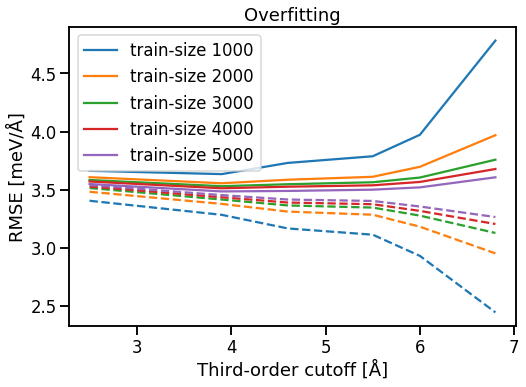

In [11]:
plt.figure(figsize=(8, 5.5))

for train_size in train_sizes:
    df2 = df[df.train_size==train_size]
    line = plt.plot(df2.third_order_cutoff, 1000*df2.rmse_train, '--')
    col = line[0].get_color()
    plt.plot(df2.third_order_cutoff, 1000*df2.rmse_validation, '-', c=col,
             label='train-size {}'.format(train_size))

plt.title('Overfitting')
plt.xlabel('Third-order cutoff [Å]')
plt.ylabel('RMSE [meV/Å]')
plt.legend(loc=2)

As seen the training and validation error start to diverge after a while. This happens for larger cutoffs when the number of parameters grows larger and becomes comparable to the training set size. Thus, and as seen, increasing the training set size decreases overfitting.

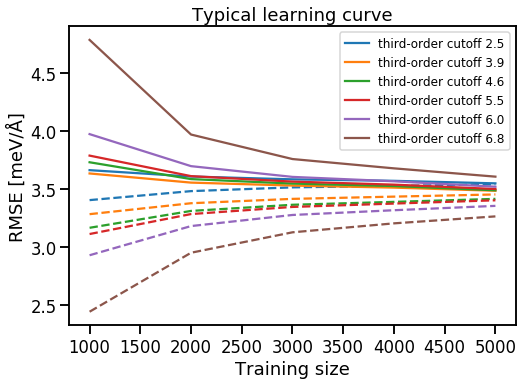

In [12]:
plt.figure(figsize=(8, 5.5))

for cutoff in cutoffs:
    df2 = df[df.third_order_cutoff == cutoff]
    line = plt.plot(df2.train_size, 1000*df2.rmse_train, '--')
    col = line[0].get_color()
    plt.plot(df2.train_size, 1000*df2.rmse_validation, '-', c=col,
             label='third-order cutoff {}'.format(cutoff))

plt.title('Typical learning curve')
plt.xlabel('Training size')
plt.ylabel('RMSE [meV/Å]')
plt.legend(loc=1, fontsize=12)

The solid lines are validation and the dashed lines are training rmses.

This plot is basically the same data as the one before but cut differently. The training and validation score approaches each other for large enough data sets.

## Thermal conductivity
Now once we have a good choice for our second and third order force constants we could begin to compute thermal conductivities. This is beyond the scope of this tutorial since it can be quite time consuming, below we show how the thermal conductivity converges with respect to number of training structures for various fit methods such as

* OLS (ordinary least squares)
* ARDR
* RFE
* LASSO


<figure class="image">
  <img src="reference_figures/Si_kappa_9.65_4.0.png" width="50%">
  <figcaption>Thermal conductivity for Si using cutoffs 9.65, 4.0 for second and third-order respectively.</figcaption>
</figure>


<figure class="image">
  <img src="reference_figures/Si_kappa_9.65_9.65.png" width="50%">
  <figcaption>Thermal conductivity for Si using cutoffs 9.65, 9.65 for second and third-order respectively.</figcaption>
</figure>

From this we see that chosing a good cutoff can be quite important, the choice of fit method can also matter quite a bit.